# Test Factor Models VaR and ES
This notebook demonstrates how to use:
- A single-factor model Value-at-Risk (VaR) and Expected Shortfall (ES)
- A Fama-French 3-factor model for VaR and ES

It uses historical return data and factor models to estimate portfolio risk.

In [1]:
import data_download as dd
import factor_models_2 as fm
import pandas as pd
import numpy as np
import plots

##  Download data and form a portfolio

In [2]:
# Define tickers and shares
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "JPM",
    "UNH", "KO", "PEP", "BMW.DE", "NESN.SW",
    "NOVN.SW", "ASML.AS"
]

# Assign number of shares per asset
shares = pd.Series(10, index=tickers)

# Download adjusted prices
prices = dd.get_raw_prices(tickers, start="2022-01-01")

# Compute daily value of each position
position_values = prices * shares

# Compute total portfolio value over time
portfolio_value_series = position_values.sum(axis=1)

# Compute asset weights (based on latest available prices)
latest_prices = prices.iloc[-1]
port_val = (shares * latest_prices).sum()
weights = (shares * latest_prices) / port_val

# Compute daily asset returns and portfolio returns
returns = prices.pct_change().dropna()
portfolio_returns = returns @ weights

# Combine historical values into one DataFrame
portfolio_df = position_values.copy()
portfolio_df["PORTFOLIO"] = portfolio_value_series

# Display results
portfolio_df.head()


,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH,PORTFOLIO
Date,,,,,,,,,,,,,
2022-01-03,1788.799286,6772.233887,736.722031,1443.016052,1469.958344,537.828445,3256.347351,1150.985565,649.150009,300.682240,1572.986298,4789.945068,24468.654575
2022-01-04,1766.096191,6575.348511,759.792480,1437.124176,1525.683746,546.807327,3200.511169,1153.479538,650.281372,292.386818,1575.259705,4681.421204,24164.192238
2022-01-05,1719.118195,6474.976807,776.328964,1371.194305,1497.791443,551.342163,3077.650146,1122.304382,655.372391,275.556316,1580.625458,4669.882507,23772.143078
2022-01-06,1690.420837,6355.302734,776.167679,1370.920715,1513.703766,548.439789,3053.330994,1119.810333,659.412994,281.286221,1580.988770,4478.772278,23428.557110
2022-01-07,1692.091064,6417.071533,771.166382,1363.650513,1528.701630,547.170105,3054.886780,1108.587418,660.463486,271.992569,1582.989349,4373.395691,23372.166519


## Single-Factor VaR and ES

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [3]:
# download SP prices
spy = dd.get_raw_prices(["^GSPC"], start="2022-01-01")

# compute benchmark returns
benchmark = spy["^GSPC"].pct_change().dropna()

# align benchmark with asset returns
benchmark = benchmark.reindex(returns.index).ffill()

In [5]:
results_df, var_sf, es_sf = fm.sharpe_model(
    returns=returns,
    benchmark=benchmark,
    weights=weights,
    port_val=port_val,
    confidence_level=0.99
)


In [ ]:
results_df.head()   

,Returns,VaR,ES,VaR Violation,VaR_monetary,ES_monetary
Date,,,,,,
2022-01-04,-0.010253,0.027765,0.031809,False,729.207727,835.42742
2022-01-05,-0.018989,0.027765,0.031809,False,729.207727,835.42742
2022-01-06,-0.010985,0.027765,0.031809,False,729.207727,835.42742
2022-01-07,-0.002226,0.027765,0.031809,False,729.207727,835.42742
2022-01-10,-0.011923,0.027765,0.031809,False,729.207727,835.42742



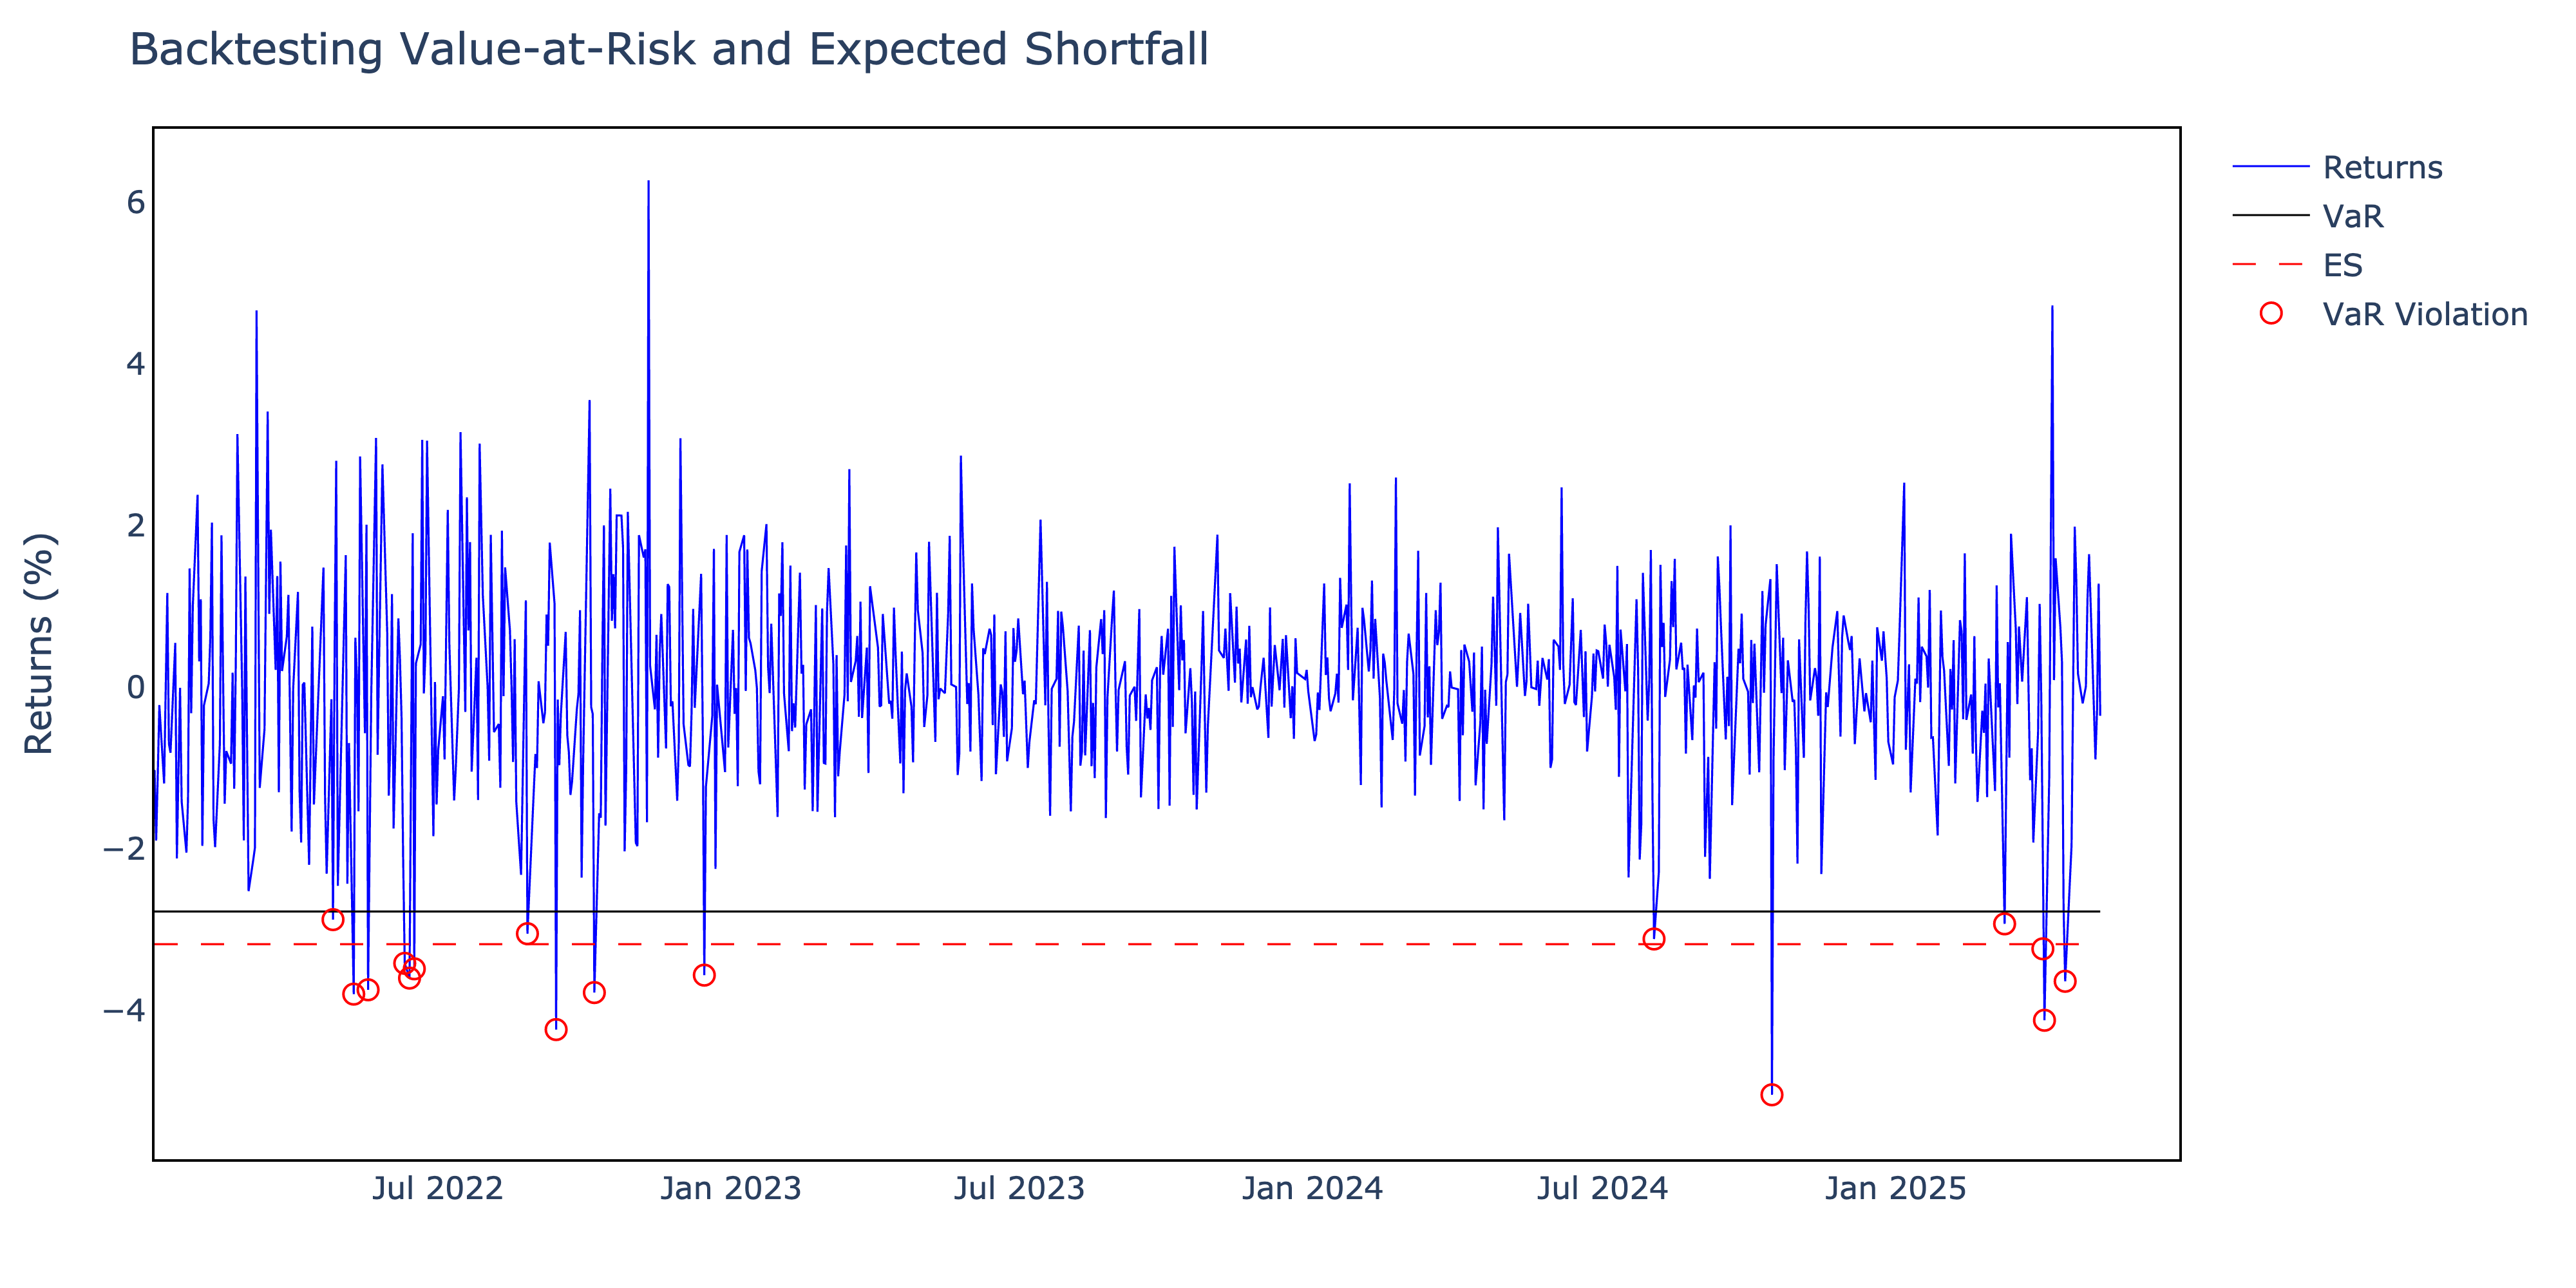

In [6]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

## Fama-French 3-Factor VaR and ES

The Fama–French 3-factor model extends the CAPM by modeling asset returns using three sources of systematic risk:

- **Mkt_RF**: excess return of the market over the risk-free rate  
- **SMB** ("Small Minus Big"): return of small-cap stocks minus large-cap  
- **HML** ("High Minus Low"): return of high book-to-market stocks minus low  

Each asset’s excess return is regressed on these three factors to estimate its **exposures (betas)**. The model assumes:

$$
R_i - R_f = \alpha_i + \beta_{i1} \cdot \text{Mkt}_{RF} + \beta_{i2} \cdot \text{SMB} + \beta_{i3} \cdot \text{HML} + \varepsilon_i
$$

The estimated covariance matrix of asset returns is reconstructed as:

$$
\Sigma = B \cdot \Sigma_f \cdot B^T + D
$$

Where:
- $B$: matrix of asset betas  
- $\Sigma_f$: covariance matrix of factor returns  
- $D$: diagonal matrix of idiosyncratic variances  

The next code block performs the following steps:

1. Downloads the FF3 daily factor data from Ken French's database.
2. Computes **excess returns** for each asset over the risk-free rate.
3. Regresses each asset’s excess return on the three factors to obtain:
   - **Beta coefficients** (exposures to Mkt_RF, SMB, HML)
   - **Idiosyncratic variance** (residual risk)
4. Builds the **full covariance matrix** of asset returns using the factor structure.
5. Computes **portfolio volatility** using the covariance matrix and current weights.
6. Calculates:
   - **Value-at-Risk (VaR)** at the given confidence level
   - **Conditional VaR (CVaR)**, i.e. expected loss beyond the VaR threshold

The printed outputs show all key components estimated during this process.

In [ ]:
# # Download FF3 daily factors and restrict to portfolio date range
# ff_factors = fm.load_ff3_factors(start=returns.index[0], end=returns.index[-1])

# # Check first few rows
# ff_factors.head()

In [12]:
new_df, var_ff, es_ff = fm.fama_french_model(
    prices=prices, 
    shares=shares, 
    confidence_level=0.99
)

new_df.head()

,Returns,VaR,ES,VaR Violation,VaR_monetary,ES_monetary
Date,,,,,,
2022-01-04,-0.010253,0.026804,0.030708,False,703.964754,806.507442
2022-01-05,-0.018989,0.026804,0.030708,False,703.964754,806.507442
2022-01-06,-0.010985,0.026804,0.030708,False,703.964754,806.507442
2022-01-07,-0.002226,0.026804,0.030708,False,703.964754,806.507442
2022-01-10,-0.011923,0.026804,0.030708,False,703.964754,806.507442



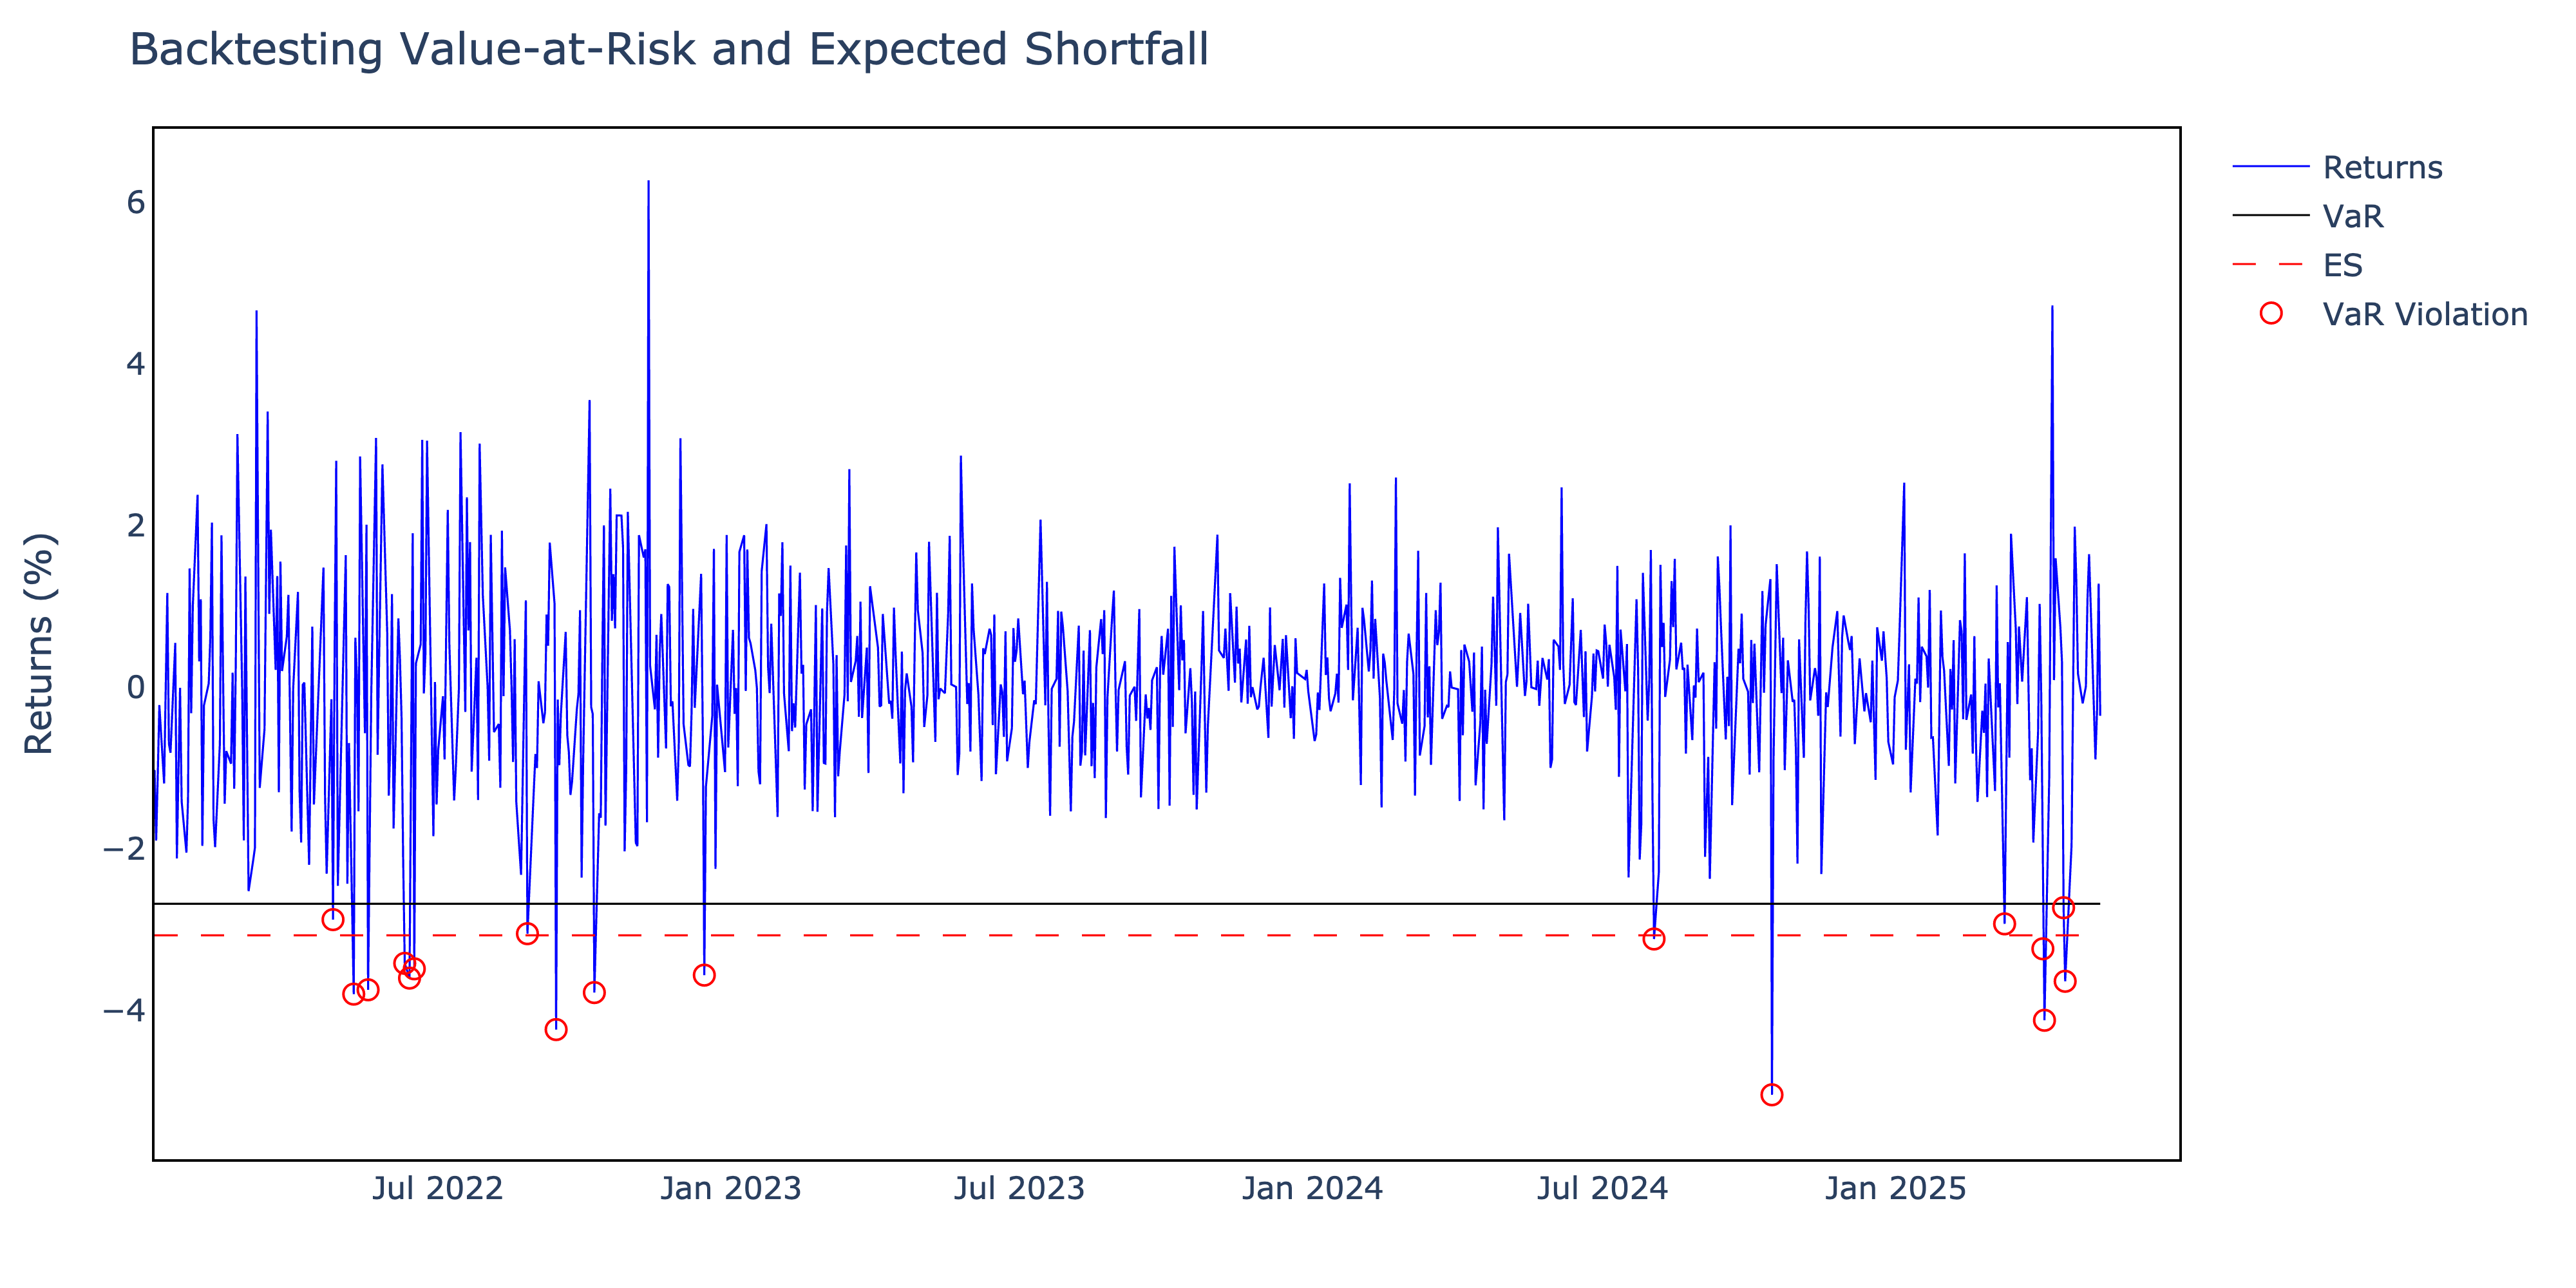

In [13]:
# Plot interactive VaR
fig_var = plots.plot_backtest(new_df, interactive=False)